In [31]:
import numpy as np
import csv
import scipy as sp
import matplotlib.pyplot as plt
import scipy.interpolate
import random

In [9]:
lon = []
lat = []
elev = []
with open('processed_welldata.csv', newline='') as csvf:
    spamreader = csv.reader(csvf, delimiter=',')
    for i, row in enumerate(spamreader):
        if i == 0:
            continue
        lat.append(float(row[1]))
        lon.append(float(row[2]))
        elev.append(float(row[3]))

        

In [10]:
len(lat)

79053

In [11]:
len(np.unique(lat))
len(np.unique(lon))

67525

In [36]:
spline = sp.interpolate.Rbf(lat[1:1000],lon[0:1000],elev[0:1000],function='thin_plate',smooth=3, episilon=5)

In [37]:
spline(lat[0:1000],lon[0:1000])[0:10]

array([198.92599196, 153.34282717, 166.08442238, 175.68469701,
       172.90930391, 138.50283288, 148.97676188, 125.41934396,
       153.7165652 , 130.63376052])

In [38]:
elev[0:10]

['96.10077598704',
 '51.1733229516',
 '106.65735951696',
 '98.52313043112',
 '59.20020044112',
 '77.2098918588',
 '110.37592323552',
 '89.16013915968',
 '81.37241918016',
 '118.499715756']

## Extract points in Kendall county

In [16]:
corners_champaign = [(40.398855, -88.459827), (39.880882, -87.939255)]
corners_kendall = [(41.720347, -88.603715), (41.463580, -88.252839)]

def extract_county(lat, lon, corners):
    idx = []
    for i in range(len(lat)):
        if lat[i] >= corners[1][0] and corners[0][0] >= lat[i]:
            if lon[i] >= corners[0][1] and corners[1][1] >= lon[i]:
                idx.append(i)
    return idx

In [17]:
idx_kendall = extract_county(lat, lon, corners_kendall)

In [18]:
len(idx_kendall)

1856

## Run interpolation for Kendall County

In [26]:
lat_kendall = np.array([lat[i] for i in idx_kendall])
lon_kendall = np.array([lon[i] for i in idx_kendall])
elev_kendall = np.array([elev[i] for i in idx_kendall])
spline_kendall = sp.interpolate.Rbf(lat_kendall, lon_kendall, elev_kendall,
                                    function='thin_plate',smooth=3, episilon=5)

## Check residuals for outliers

In [29]:
residual_kendall = np.subtract(elev_kendall, spline_kendall(lat_kendall, lon_kendall))

In [30]:
len(residual_kendall)

1856

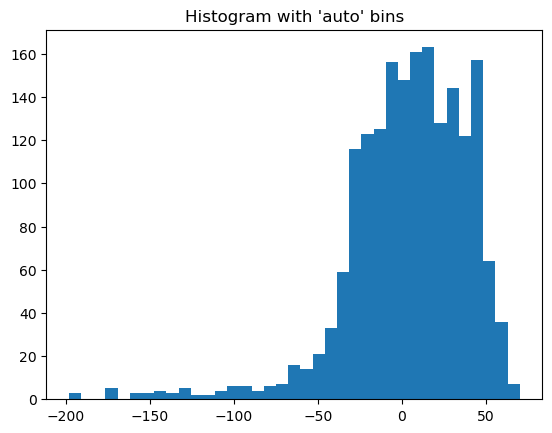

In [32]:
_ = plt.hist(residual_kendall, bins='auto')  # arguments are passed to np.histogram
plt.title("Histogram with 'auto' bins")
plt.show()

In [41]:
outliers = [i for i in range(len(residual_kendall)) if abs(residual_kendall[i]) > 100]

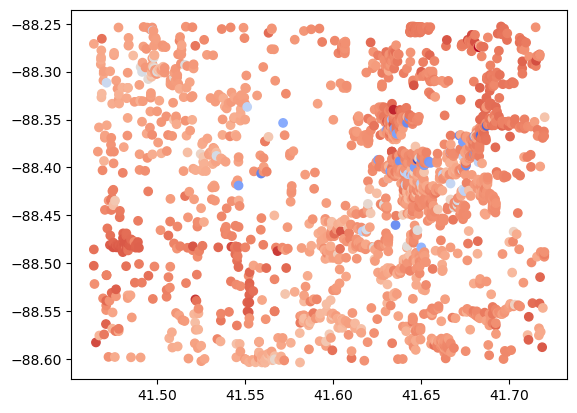

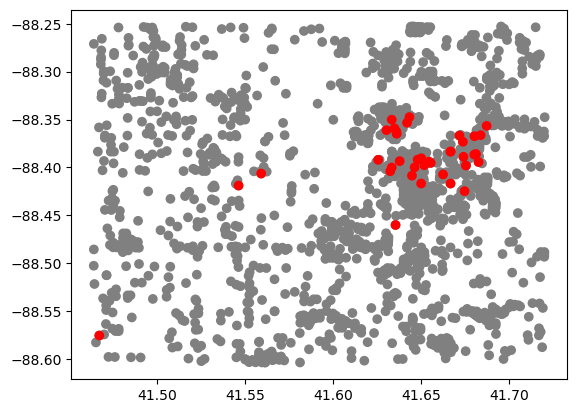

In [51]:
plt.scatter(lat_kendall, lon_kendall, c=elev_kendall, cmap='coolwarm')
plt.show()
plt.scatter(list(lat_kendall)+[lat_kendall[i] for i in outliers],
            list(lon_kendall)+[lon_kendall[i] for i in outliers],
            c = ['gray']*len(lon_kendall)+['red']*len(outliers))
plt.show()
